# Herron Topic 2 - Practice for Section 03

## Announcements

1. Project 2 is due Friday, 3/29, at 11:59 PM
2. We will dedicate class next week to group work and easy access to me (i.e., no pre-class quiz)

## 10-Minute Recap

1. Technical analysis studies market trends to estimate where prices may go. It looks for patterns in past price moves and trade volumes, and traders use these signals to inform their trades.
2. There is little evidence that technical analysis works, but it provides a context for us to introduce quantitative investing strategies.
3. *We should never base trades on information we do not have at the time of the trade!*

##  Practice

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
%config InlineBackend.figure_format = 'retina'

### Implement the SMA(20) strategy with Bitcoin from the lecture notebook

I suggest writing a function `calc_sma()` that accepts a data frame `df` and moving average window `n`.
First, we need the data, from ticker `BTC-USD` from Yahoo! Finance.

In [3]:
btc = (
    yf.download('BTC-USD')
    .rename_axis(columns='Variable')
)

btc.head(10)

[*********************100%%**********************]  1 of 1 completed


Variable,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.8640,468.1740,452.4220,457.3340,457.3340,21056800
2014-09-18,456.8600,456.8600,413.1040,424.4400,424.4400,34483200
2014-09-19,424.1030,427.8350,384.5320,394.7960,394.7960,37919700
2014-09-20,394.6730,423.2960,389.8830,408.9040,408.9040,36863600
2014-09-21,408.0850,412.4260,393.1810,398.8210,398.8210,26580100
2014-09-22,399.1000,406.9160,397.1300,402.1520,402.1520,24127600
2014-09-23,402.0920,441.5570,396.1970,435.7910,435.7910,45099500
2014-09-24,435.7510,436.1120,421.1320,423.2050,423.2050,30627700
2014-09-25,423.1560,423.5200,409.4680,411.5740,411.5740,26814400


Next, we write a function, since we might want to calculate simple moving averages (SMAs) more than once.
The following `calc_sma()` function accepts:

1. A data frame `df` of daily values from `yfinance.download()`
2. An integer `n` that specifies the number of trading days in the SMA window

And returns the original data frame `df` plus the following columns:

1. `Return` for the daily returns
2. `SMA` for the `n`-trading-day moving average
3. `Signal` for the weight on the security for each day
4. `Strategy` for the return on the SMA strategy

In [4]:
def calc_sma(df, n):
    return (
        df
        .assign(
            Return=lambda x: x['Adj Close'].pct_change(),
            SMA=lambda x: x['Adj Close'].rolling(n).mean(),
            Signal=lambda x: np.select(
                condlist=[x['Adj Close'].shift(1)>x['SMA'].shift(1), x['Adj Close'].shift(1)<=x['SMA'].shift(1)],
                choicelist=[1, 0],
                default=np.nan
            ),
            Strategy=lambda x: x['Signal'] * x['Return']
        )
    )

Finally, we calculate the SMA(20).
We can drop the last row to avoid partial trading-day returns.
Recall the last row from `yfinance.download()` may not be at the close.

In [5]:
btc_sma = btc.iloc[:-1].pipe(calc_sma, n=20)

btc_sma.tail()

Variable,Open,High,Low,Close,Adj Close,Volume,Return,SMA,Signal,Strategy
Date,,,,,,,,,,
2024-03-17,65316.3438,68845.7188,64545.3164,68390.6250,68390.6250,44716864318,0.0471,66530.1934,0.0000,0.0000
2024-03-18,68371.3047,68897.1328,66594.2266,67548.5938,67548.5938,49261579492,-0.0123,67053.3545,1.0000,-0.0123
2024-03-19,67556.1328,68106.9297,61536.1797,61912.7734,61912.7734,74215844794,-0.0834,67023.7537,1.0000,-0.0834
2024-03-20,61930.1562,68115.2578,60807.7852,67913.6719,67913.6719,66792634382,0.0969,67359.5182,0.0000,0.0000
2024-03-21,67911.5859,68199.9922,64580.9180,65491.3906,65491.3906,44480350565,-0.0357,67512.0561,1.0000,-0.0357


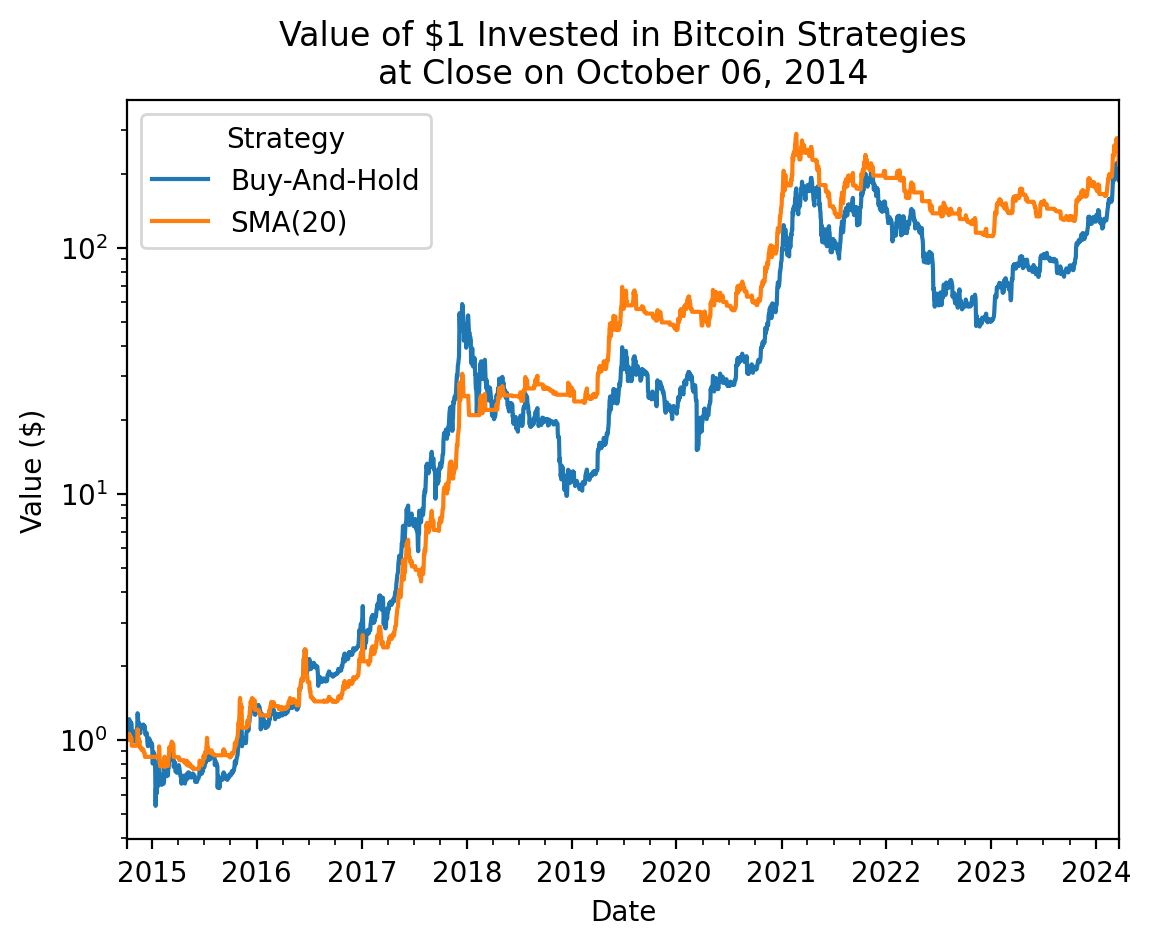

In [6]:
names_sma = {'Return': 'Buy-And-Hold', 'Strategy': 'SMA(20)'}

_ = (
    btc_sma
    [['Return', 'Strategy']]
    .dropna()
)

(
    _
    .add(1)
    .cumprod()
    .rename_axis(columns='Strategy')
    .rename(columns=names_sma)
    .plot(logy=True)
)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested in Bitcoin Strategies\nat Close on {_.index[0] - pd.offsets.Day(1):%B %d, %Y}')
plt.show()

### How does SMA(20) outperform buy-and-hold with this sample?

Consider the following:

1. Does SMA(20) avoid the worst performing days? How many of the worst 20 days does SMA(20) avoid? Try the `.sort_values()` or `.nlargest()` method.
1. Does SMA(20) preferentially avoid low-return days? Try to combine the `.groupby()` method and `pd.qcut()` function.
1. Does SMA(20) preferentially avoid high-volatility days? Try to combine the `.groupby()` method and `pd.qcut()` function.

In [7]:
btc_sma[['Return', 'Strategy']].add(1).prod()

Variable
Return     143.2025
Strategy   217.6557
dtype: float64

In [8]:
btc_sma['Return'].nsmallest(20)

Date
2020-03-12   -0.3717
2015-01-14   -0.2114
2017-09-14   -0.1874
2015-08-18   -0.1818
2018-01-16   -0.1685
2022-06-13   -0.1597
2018-02-05   -0.1597
2015-01-13   -0.1566
2016-01-15   -0.1533
2022-11-09   -0.1435
2017-01-11   -0.1431
2019-06-27   -0.1409
2021-05-19   -0.1377
2018-11-19   -0.1337
2021-05-12   -0.1332
2021-01-21   -0.1328
2019-07-16   -0.1301
2017-12-22   -0.1247
2017-01-05   -0.1224
2017-12-30   -0.1163
Name: Return, dtype: float64

The SMA(20) does well here because it avoids 17 of the 20 worst days, without avoiding the best days.

In [9]:
btc_sma.loc[btc_sma['Return'].nsmallest(20).index, 'Signal'].value_counts()

Signal
0.0000    17
1.0000     3
Name: count, dtype: int64

In [10]:
btc_sma.loc[btc_sma['Return'].nlargest(100).index, 'Signal'].value_counts()

Signal
0.0000    52
1.0000    47
Name: count, dtype: int64

In [11]:
(
    btc_sma
    .rename(columns={'Return': 'Buy-And-Hold', 'Strategy': 'SMA(20)'})
    .groupby('Signal')
    [['Buy-And-Hold', 'SMA(20)']]
    .describe()
    .rename_axis(columns=['Strategy', 'Statistic'])
    .stack('Strategy')
)

Statistic               count   mean    std     min     25%    50%    75%  \
Signal Strategy                                                             
0.0000 Buy-And-Hold 1542.0000 0.0008 0.0401 -0.3717 -0.0138 0.0015 0.0163   
       SMA(20)      1542.0000 0.0000 0.0000  0.0000  0.0000 0.0000 0.0000   
1.0000 Buy-And-Hold 1912.0000 0.0034 0.0339 -0.1409 -0.0112 0.0015 0.0175   
       SMA(20)      1912.0000 0.0034 0.0339 -0.1409 -0.0112 0.0015 0.0175   

Statistic              max  
Signal Strategy             
0.0000 Buy-And-Hold 0.2394  
       SMA(20)      0.0000  
1.0000 Buy-And-Hold 0.2525  
       SMA(20)      0.2525

We can also use the seaborn package to visualize `Signal` (i.e., the portfolio weight on Bitcoin) during periods of high and low Bitcoin returns and volatility.
The SMA(20) strategy is long Bitcoin about 55% of the time, with Bitcoin returns are high (bin 2) or low (bin 1).

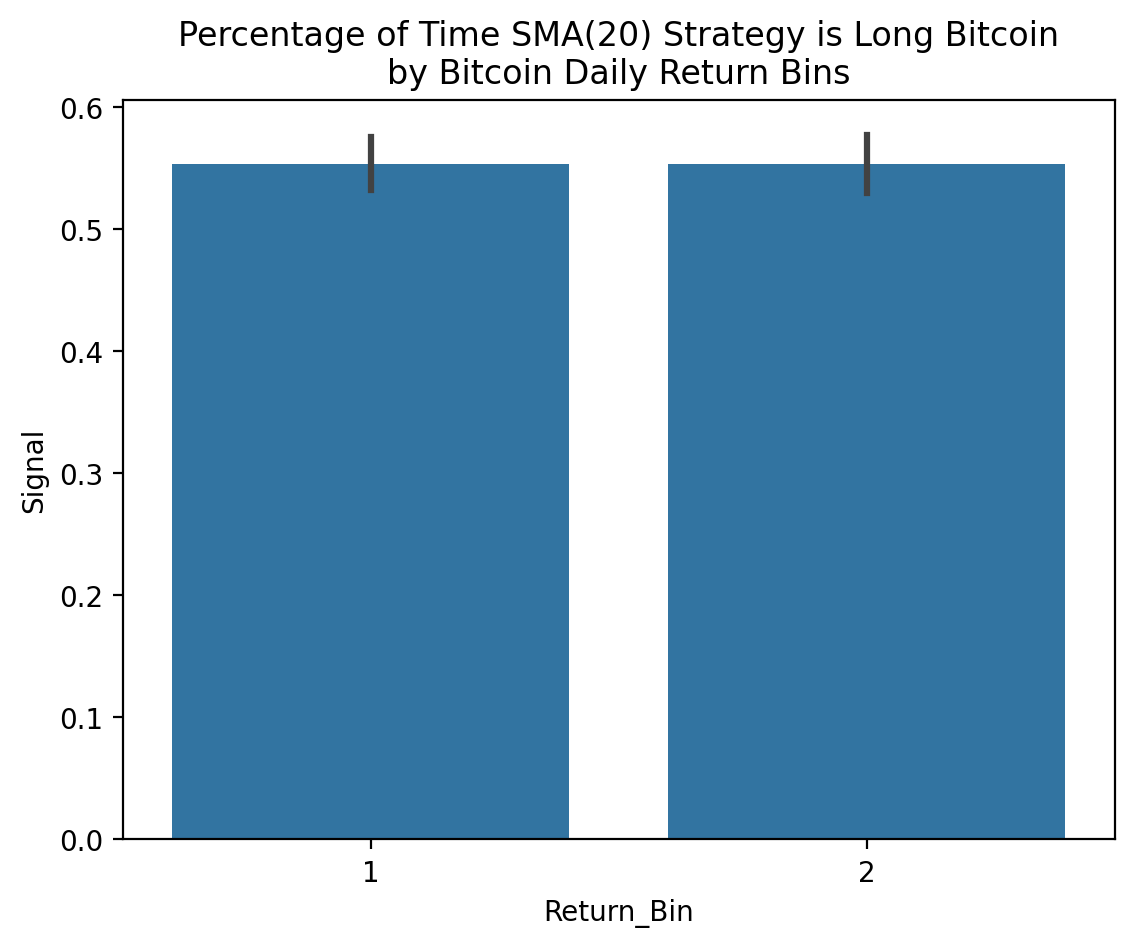

In [12]:
(
    btc_sma
    [['Return', 'Signal']]
    .dropna()
    .assign(Return_Bin=lambda x: 1 + pd.qcut(x['Return'], q=2, labels=False))
    .pipe(
        sns.barplot,
        x='Return_Bin',
        y='Signal'
    )
)

plt.title('Percentage of Time SMA(20) Strategy is Long Bitcoin\nby Bitcoin Daily Return Bins')
plt.show()

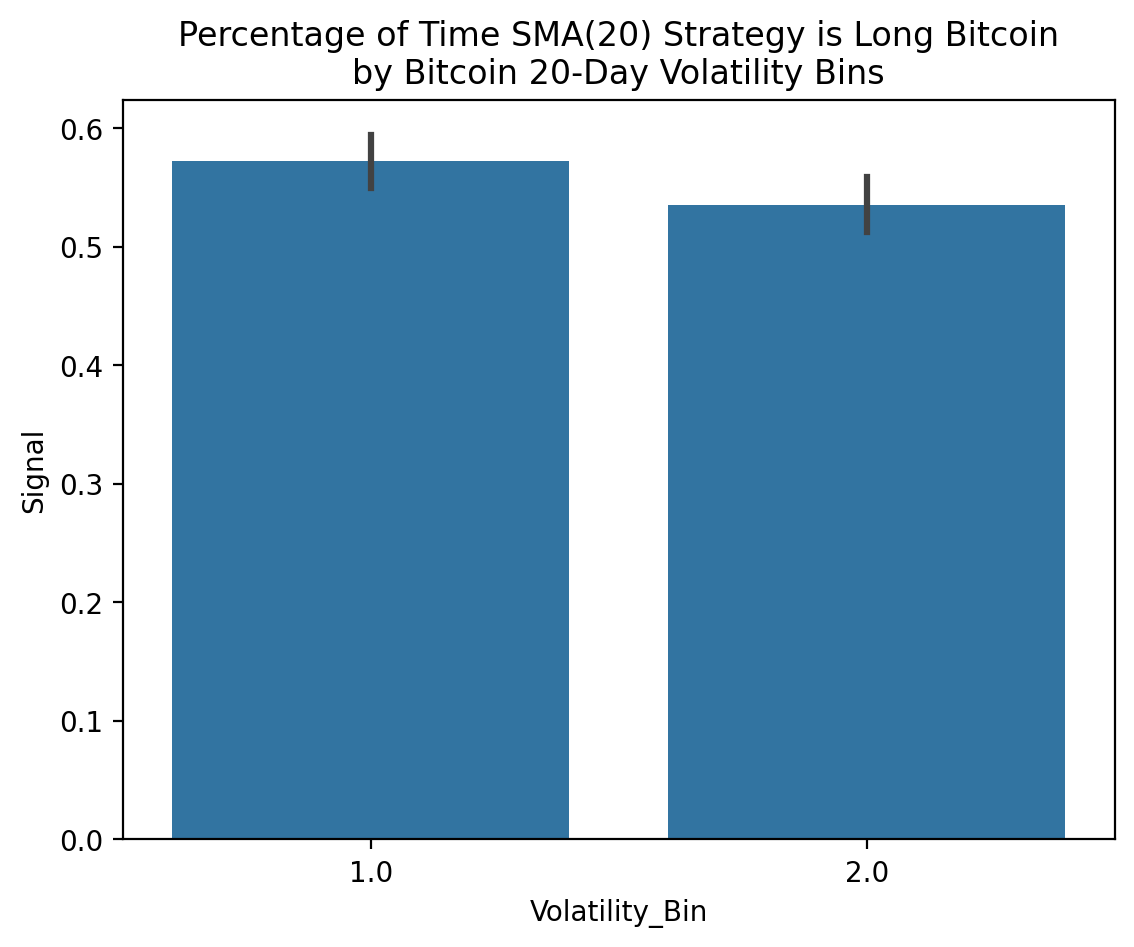

In [13]:
(
    btc_sma
    [['Return', 'Signal']]
    .dropna()
    .assign(Volatility_Bin=lambda x: 1 + pd.qcut(x['Return'].rolling(20).std(), q=2, labels=False))
    .pipe(
        sns.barplot,
        x='Volatility_Bin',
        y='Signal'
    )
)

plt.title('Percentage of Time SMA(20) Strategy is Long Bitcoin\nby Bitcoin 20-Day Volatility Bins')
plt.show()

### Implement the SMA(20) strategy with the market factor from French

We need to impute a market price before we calculate SMA(20).

In [14]:
ff = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900'
    )
    [0]
    .div(100)
    .assign(
        Mkt=lambda x: x['Mkt-RF'] + x['RF'],
        Price=lambda x: x['Mkt'].add(1).cumprod()
    )
)

C:\Users\r.herron\AppData\Local\Temp\ipykernel_10212\2105953079.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


In [15]:
ff_sma = (
    ff
    .rename(columns={'Price': 'Adj Close'})
    .pipe(calc_sma, n=20)
)

ff_sma.tail()

,Mkt-RF,SMB,HML,RF,Mkt,Adj Close,Return,SMA,Signal,Strategy
Date,,,,,,,,,,
2024-01-25,0.0046,0.0004,0.0056,0.0002,0.0048,11969.2170,0.0048,11716.9236,1.0000,0.0048
2024-01-26,-0.0002,0.0040,-0.0027,0.0002,0.0000,11969.4564,0.0000,11727.1312,1.0000,0.0000
2024-01-29,0.0085,0.0107,-0.0059,0.0002,0.0087,12073.8301,0.0087,11742.4928,1.0000,0.0087
2024-01-30,-0.0013,-0.0126,0.0084,0.0002,-0.0011,12060.7903,-0.0011,11759.6086,1.0000,-0.0011
2024-01-31,-0.0174,-0.0092,-0.0030,0.0002,-0.0172,11853.5860,-0.0172,11770.3368,1.0000,-0.0172


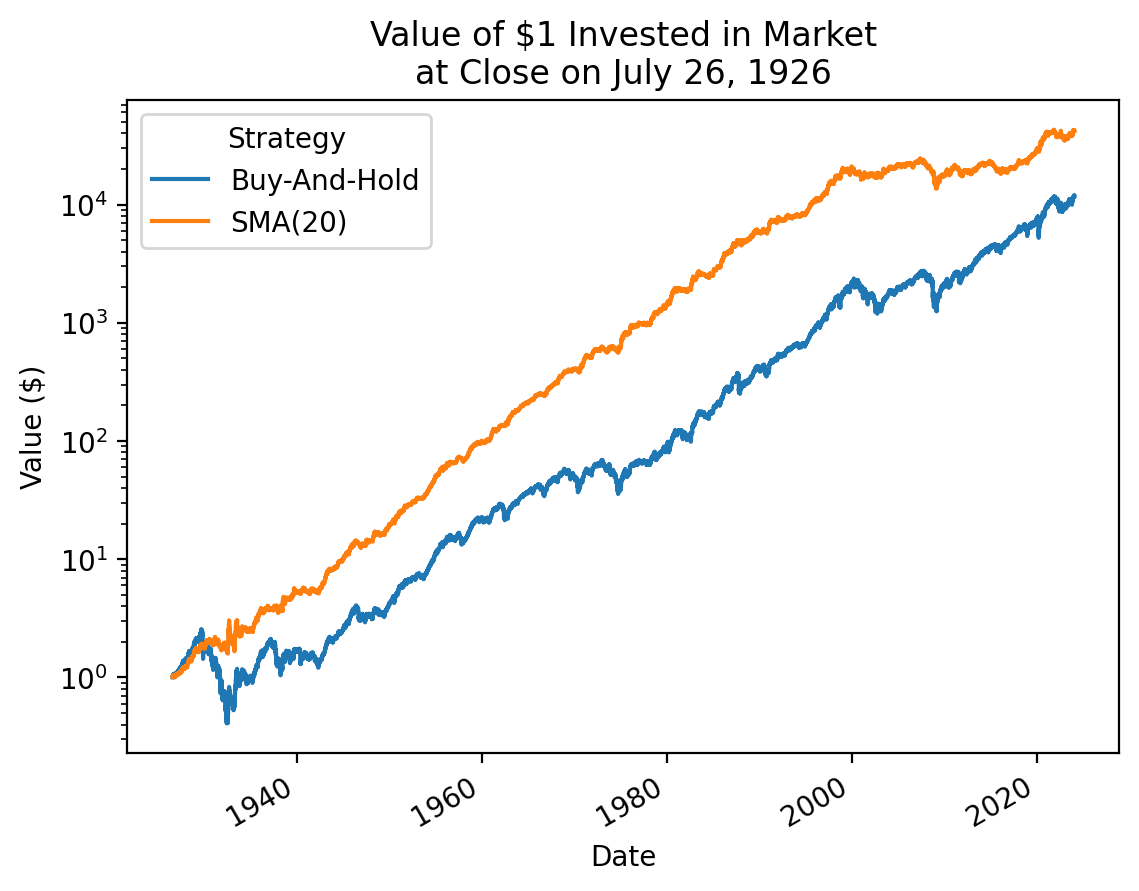

In [16]:
_ = ff_sma[['Return', 'Strategy']].dropna()

(
    _
    .add(1)
    .cumprod()
    .rename_axis(columns='Strategy')
    .rename(columns=names_sma)
    .plot(logy=True)
)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested in Market\nat Close on {_.index[0] - pd.offsets.BDay(1):%B %d, %Y}')
plt.show()

### How often does SMA(20) outperform buy-and-hold with 1-year rolling windows with Bitcoin?

SMA(20) > Buy-And-Hold for One-Year Rolling Window:
False    2111
True     1363
Name: count, dtype: int64


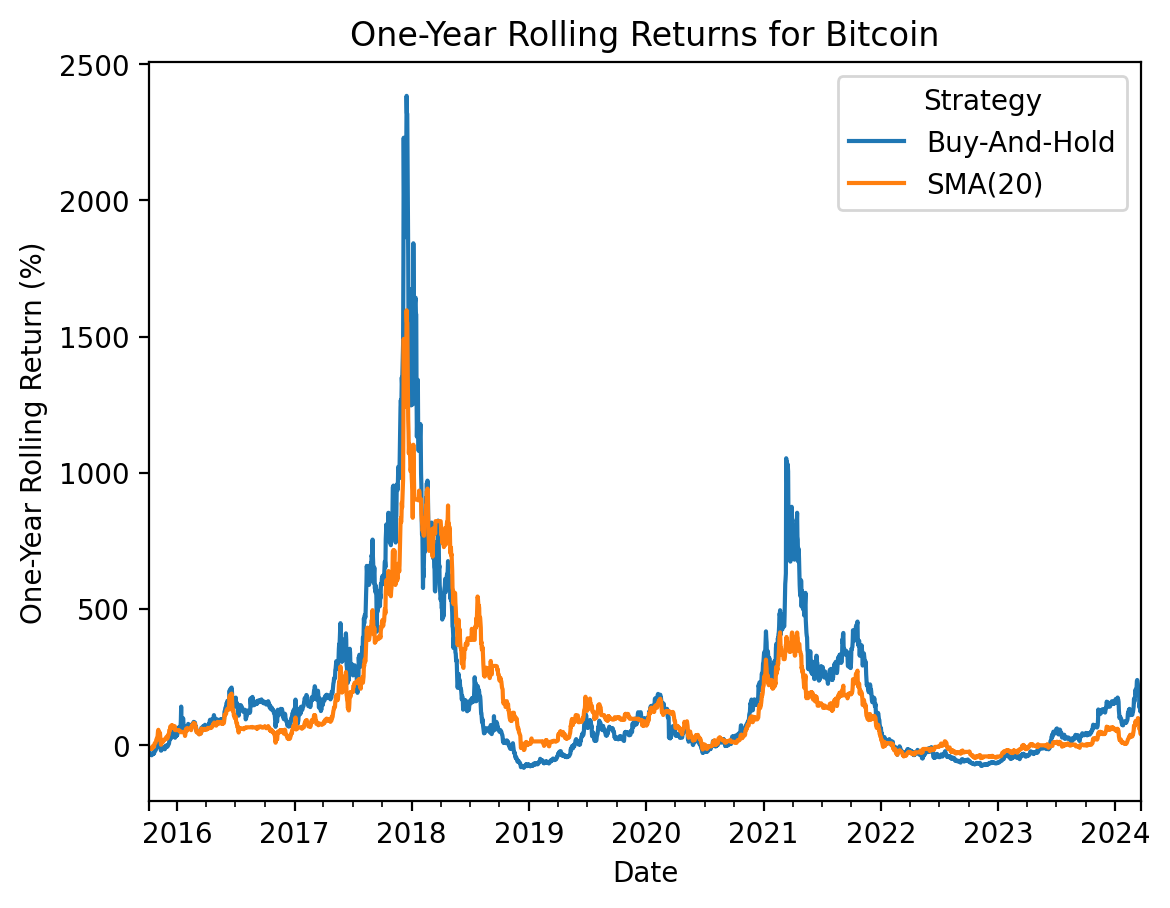

In [17]:
_ = (
    btc_sma
    [['Return', 'Strategy']]
    .pipe(np.log1p)
    .rolling(365)
    .sum()
    .pipe(np.expm1)
)

(
    _
    .dropna()
    .mul(100)
    .rename(columns=names_sma)
    .rename_axis(columns='Strategy')
    .plot()
)

plt.title('One-Year Rolling Returns for Bitcoin')
plt.ylabel('One-Year Rolling Return (%)')

print(
    f'{names_sma['Strategy']} > {names_sma['Return']} for One-Year Rolling Window:',
    (_['Strategy'] > _['Return']).value_counts(),
    sep='\n'
)


### Implement a long-only BB(20, 2) strategy with Bitcoin

More on Bollinger Bands [here](https://www.bollingerbands.com/bollinger-bands) and [here](https://www.bollingerbands.com/bollinger-band-rules).
In short, Bollinger Bands are bands around a trend, typically defined in terms of simple moving averages and volatilities.
Here, long-only BB(20, 2) implies we have upper and lower bands at 2 standard deviations above and below SMA(20):

1. Buy when the closing price crosses LB(20) from below, where LB(20) is SMA(20) minus 2 sigma
1. Sell when the closing price crosses UB(20) from above, where UB(20) is SMA(20) plus 2 sigma
1. No short-selling

The long-only BB(20, 2) is more difficult to implement than the long-only SMA(20) because we need to track buys and sells.
For example, if the closing price is between LB(20) and BB(20), we need to know if our last trade was a buy or a sell.
Further, if the closing price is below LB(20), we can still be long because we sell when the closing price crosses UB(20) from above.

Here is a function to calculate Bolling Bands and implement the strategy.

In [18]:
def calc_bb(df, m, n):
    return (
        df
        .assign(
            Return=lambda x: x['Adj Close'].pct_change(),
            SMA=lambda x: x['Adj Close'].rolling(m).mean(),
            SMV=lambda x: x['Adj Close'].rolling(m).std(),
            UB=lambda x: x['SMA'] + n*x['SMV'],
            LB=lambda x: x['SMA'] - n*x['SMV'],
            Signal_with_nan=lambda x: np.select(
                condlist=[
                    (x['Adj Close'].shift(1) > x['LB'].shift(1)) & (x['Adj Close'].shift(2) <= x['LB'].shift(2)),
                    (x['Adj Close'].shift(1) < x['UB'].shift(1)) & (x['Adj Close'].shift(2) >= x['UB'].shift(2))
                ],
                choicelist=[
                    1,
                    0
                ],
                default=np.nan
            ),
            Signal=lambda x: x['Signal_with_nan'].ffill(),
            Strategy=lambda x: x['Signal'] * x['Return']
        )
    )


In [19]:
btc_bb = btc.iloc[:-1].pipe(calc_bb, m=20, n=2)

btc_bb.tail()

Variable,Open,High,Low,Close,Adj Close,Volume,Return,SMA,SMV,UB,LB,Signal_with_nan,Signal,Strategy
Date,,,,,,,,,,,,,,
2024-03-17,65316.3438,68845.7188,64545.3164,68390.6250,68390.6250,44716864318,0.0471,66530.1934,4242.5090,75015.2113,58045.1755,NaN,0.0000,0.0000
2024-03-18,68371.3047,68897.1328,66594.2266,67548.5938,67548.5938,49261579492,-0.0123,67053.3545,3615.2985,74283.9515,59822.7575,NaN,0.0000,-0.0000
2024-03-19,67556.1328,68106.9297,61536.1797,61912.7734,61912.7734,74215844794,-0.0834,67023.7537,3656.6873,74337.1284,59710.3790,NaN,0.0000,-0.0000
2024-03-20,61930.1562,68115.2578,60807.7852,67913.6719,67913.6719,66792634382,0.0969,67359.5182,3392.3919,74144.3020,60574.7343,NaN,0.0000,0.0000
2024-03-21,67911.5859,68199.9922,64580.9180,65491.3906,65491.3906,44480350565,-0.0357,67512.0561,3223.9829,73960.0218,61064.0903,NaN,0.0000,-0.0000


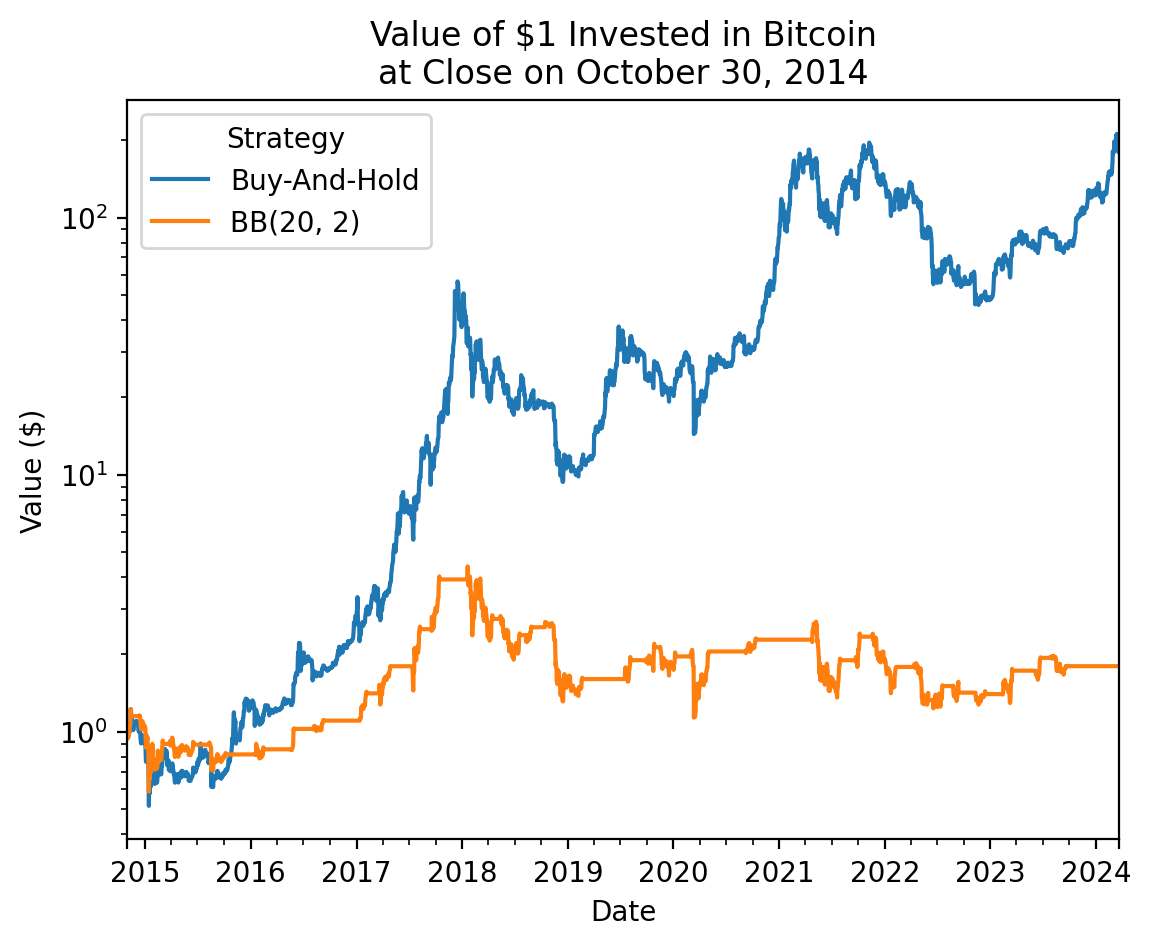

In [20]:
names_bb = {'Return': 'Buy-And-Hold', 'Strategy': 'BB(20, 2)'}

_ = (
    btc_bb
    [['Return', 'Strategy']]
    .dropna()
)

(
    _
    .add(1)
    .cumprod()
    .rename_axis(columns='Strategy')
    .rename(columns=names_bb)
    .plot(logy=True)
)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested in Bitcoin\nat Close on {_.index[0] - pd.offsets.Day(1):%B %d, %Y}')
plt.show()

Here are the final values of $1 investments, which are difficult to read on the log scale above.

In [21]:
(
    btc_bb
    [['Return', 'Strategy']]
    .rename(columns=names_bb)
    .rename_axis(columns='Strategy')
    .add(1)
    .prod()
)

Strategy
Buy-And-Hold   143.2025
BB(20, 2)        1.8011
dtype: float64

This strategy trades about 30 round-trips during this sample.

In [22]:
btc_bb['Signal'].diff().value_counts()

Signal
0.0000     3370
-1.0000      30
1.0000       29
Name: count, dtype: int64

---

We can tweak our `calc_bb()` function!

In [23]:
def calc_bb_2(df, m, n):
    return (
        df
        .assign(
            Return=lambda x: x['Adj Close'].pct_change(),
            SMA=lambda x: x['Adj Close'].rolling(m).mean(),
            SMV=lambda x: x['Adj Close'].rolling(m).std(),
            UB=lambda x: x['SMA'] + n*x['SMV'],
            LB=lambda x: x['SMA'] - n*x['SMV'],
            Signal_with_nan=lambda x: np.select(
                condlist=[
                    (x['Adj Close'].shift(1) > x['LB'].shift(1)) & (x['Adj Close'].shift(2) > x['LB'].shift(2)) & (x['Adj Close'].shift(3) <= x['LB'].shift(3)),
                    (x['Adj Close'].shift(1) < x['UB'].shift(1)) & (x['Adj Close'].shift(2) < x['UB'].shift(2)) & (x['Adj Close'].shift(3) >= x['UB'].shift(3))
                ],
                choicelist=[
                    1,
                    0
                ],
                default=np.nan
            ),
            Signal=lambda x: x['Signal_with_nan'].ffill(),
            Strategy=lambda x: x['Signal'] * x['Return']
        )
    )


In [24]:
btc_bb_2 = btc.iloc[:-1].pipe(calc_bb_2, m=20, n=2)

But this tweak does not improve performance, at least for this security and this sample.

<Axes: xlabel='Date'>

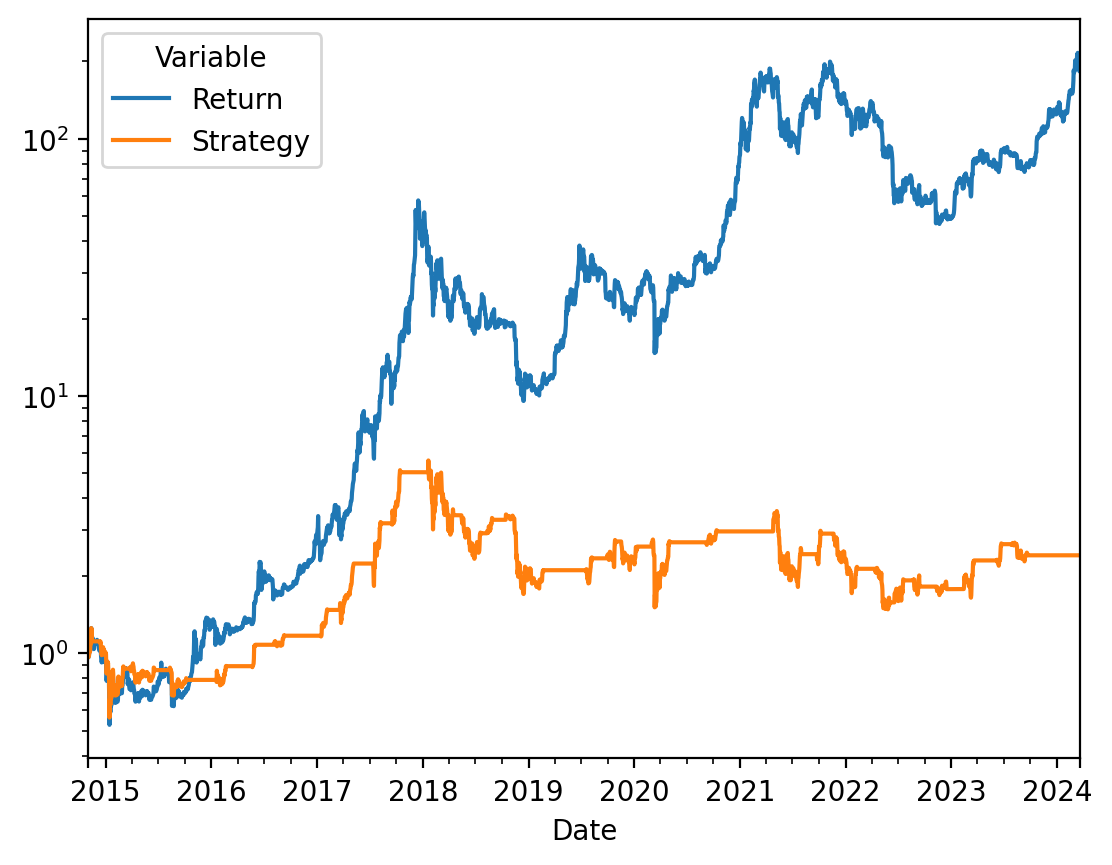

In [25]:
btc_bb_2[['Return', 'Strategy']].dropna().add(1).cumprod().plot(logy=True)

---

---

We need a more complex plot to better understand what is going on!

In [26]:
import matplotlib.ticker as ticker

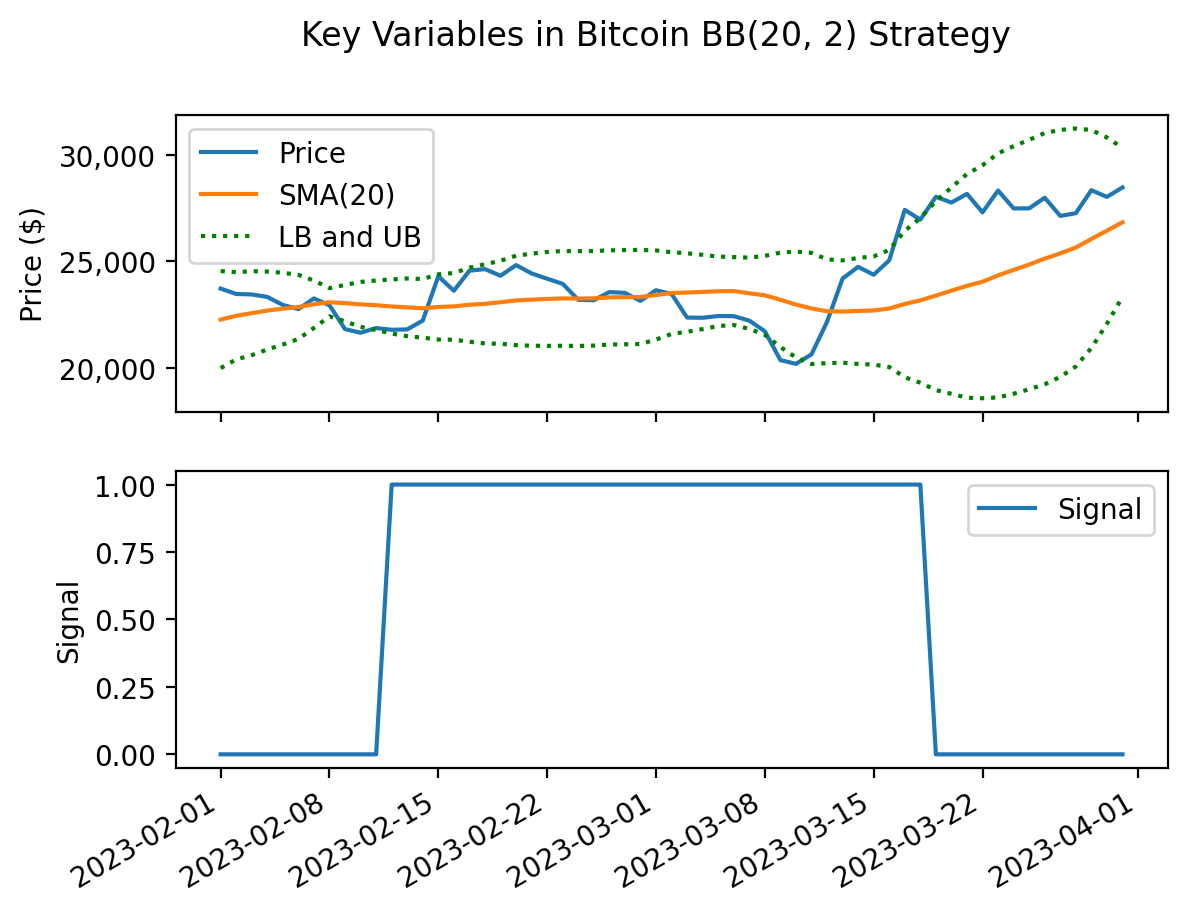

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
_ = btc_bb.loc['2023-02':'2023-03']

ax[0].plot(_[['Adj Close']], label='Price')
ax[0].plot(_[['SMA']], label='SMA(20)')
ax[0].plot(_[['UB']], label='LB and UB', color='green', linestyle=':')
ax[0].plot(_[['LB']], color='green', linestyle=':')
ax[0].legend()
ax[0].set_ylabel('Price ($)')

ax[1].plot(_[['Signal']], label='Signal')
ax[1].legend()
ax[1].set_ylabel('Signal')

ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
fig.autofmt_xdate()

plt.suptitle('Key Variables in Bitcoin BB(20, 2) Strategy')
plt.show()

---

### Implement a long-short RSI(14) strategy with Bitcoin

From [Fidelity](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/rsi):

> The Relative Strength Index (RSI), developed by J. Welles Wilder, is a momentum oscillator that measures the speed and change of price movements. The RSI oscillates between zero and 100. Traditionally the RSI is considered overbought when above 70 and oversold when below 30. Signals can be generated by looking for divergences and failure swings. RSI can also be used to identify the general trend.

Here is the RSI formula: $RSI(n) = 100 - \frac{100}{1 + RS(n)}$, where $RS(n) = \frac{SMA(U, n)}{SMA(D, n)}$.
For "up days", $U = \Delta Adj\ Close$ and $D = 0$, and, for "down days", $U = 0$ and $D = - \Delta Adj\ Close$.
Therefore, $U$ and $D$ are always non-negative.
We can learn more about RSI [here](https://en.wikipedia.org/wiki/Relative_strength_index).

We will implement a long-short RSI(14) as follows:

1. Enter a long position when  the RSI crosses 30 from below, and exit the position when the RSI crosses 50 from below
1. Enter a short position when the RSI crosses 70 from above, and exit the position when the RSI crosses 50 from above

In [28]:
def calc_rsi(df, n, lb, mb, ub):
    return df.assign(
        Return=lambda x: x['Adj Close'].pct_change(),
        Diff=lambda x: x['Adj Close'].diff(),
        U=lambda x: np.select(
            condlist=[x['Diff'] >= 0, x['Diff'] < 0],
            choicelist=[x['Diff'], 0],
            default=np.nan
        ),
        D=lambda x: np.select(
            condlist=[x['Diff'] <= 0, x['Diff'] > 0],
            choicelist=[-1 * x['Diff'], 0],
            default=np.nan
        ),
        SMAU=lambda x: x['U'].rolling(n).mean(),
        SMAD=lambda x: x['D'].rolling(n).mean(),
        RS=lambda x: x['SMAU'] / x['SMAD'],
        RSI=lambda x: 100 - 100 / (1 + x['RS']),
        Signal_with_nan = lambda x: np.select(
            condlist=[
                (x['RSI'].shift(1) >= lb) & (x['RSI'].shift(2) < lb), 
                (x['RSI'].shift(1) >= mb) & (x['RSI'].shift(2) < mb),
                (x['RSI'].shift(1) <= ub) & (x['RSI'].shift(2) > ub), 
                (x['RSI'].shift(1) <= mb) & (x['RSI'].shift(2) > mb),
            ],
            choicelist=[
                1, 
                0,
                -1,
                0
            ],
            default=np.nan
        ),
        Signal=lambda x: x['Signal_with_nan'].ffill(),
        Strategy=lambda x: x['Signal'] * x['Return']
    )

Again, we drop the last day to omit partial returns.

In [29]:
btc_rsi = btc.iloc[:-1].pipe(calc_rsi, n=14, mb=2, lb=30, ub=70)

btc_rsi.tail()

Variable,Open,High,Low,Close,Adj Close,Volume,Return,Diff,U,D,SMAU,SMAD,RS,RSI,Signal_with_nan,Signal,Strategy
Date,,,,,,,,,,,,,,,,,
2024-03-17,65316.3438,68845.7188,64545.3164,68390.6250,68390.6250,44716864318,0.0471,3075.5078,3075.5078,0.0000,1297.3906,924.3011,1.4036,58.3965,NaN,-1.0000,-0.0471
2024-03-18,68371.3047,68897.1328,66594.2266,67548.5938,67548.5938,49261579492,-0.0123,-842.0312,0.0000,842.0312,928.6018,984.4461,0.9433,48.5404,NaN,-1.0000,0.0123
2024-03-19,67556.1328,68106.9297,61536.1797,61912.7734,61912.7734,74215844794,-0.0834,-5635.8203,0.0000,5635.8203,928.6018,1063.4894,0.8732,46.6144,NaN,-1.0000,0.0834
2024-03-20,61930.1562,68115.2578,60807.7852,67913.6719,67913.6719,66792634382,0.0969,6000.8984,6000.8984,0.0000,1192.5513,1063.4894,1.1214,52.8604,NaN,-1.0000,-0.0969
2024-03-21,67911.5859,68199.9922,64580.9180,65491.3906,65491.3906,44480350565,-0.0357,-2422.2812,0.0000,2422.2812,1134.0742,1236.5095,0.9172,47.8395,NaN,-1.0000,0.0357


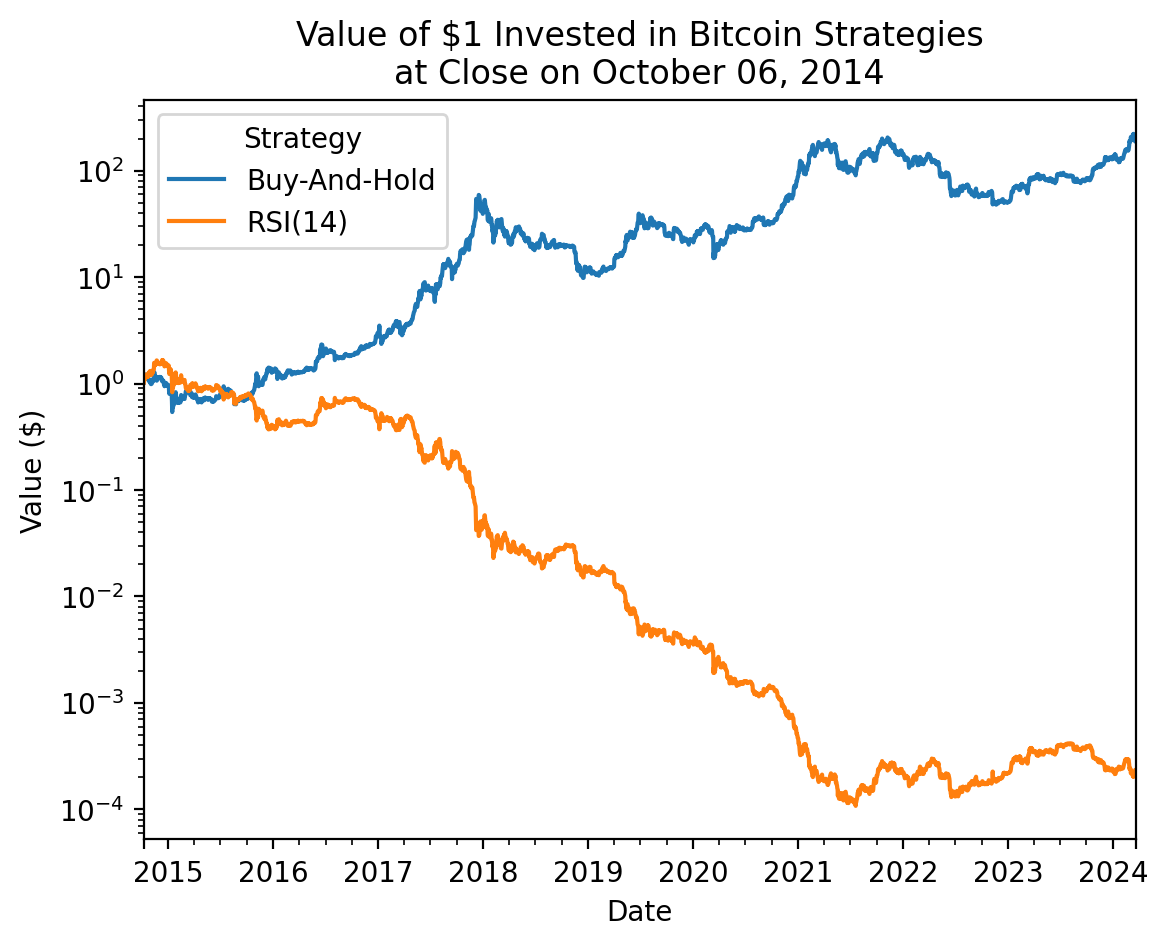

In [30]:
names_rsi = {'Return': 'Buy-And-Hold', 'Strategy': 'RSI(14)'}

_ = btc_rsi[['Return', 'Strategy']].dropna()

(
    _
    .add(1)
    .cumprod()
    .rename_axis(columns='Strategy')
    .rename(columns=names_rsi)
    .plot(logy=True)
)

plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested in Bitcoin Strategies\nat Close on {_.index[0] - pd.offsets.Day(1):%B %d, %Y}')
plt.show()

Here are the final values of $1 investments, which are difficult to read on the log scale above.

In [31]:
(
    btc_rsi
    [['Return', 'Strategy']]
    .rename(columns=names_sma)
    .rename_axis(columns='Strategy')
    .add(1)
    .prod()
)

Strategy
Buy-And-Hold   143.2025
SMA(20)          0.0002
dtype: float64

***Shorting Bitcoin has been dangerous!***

We can compare all three TA strategies!

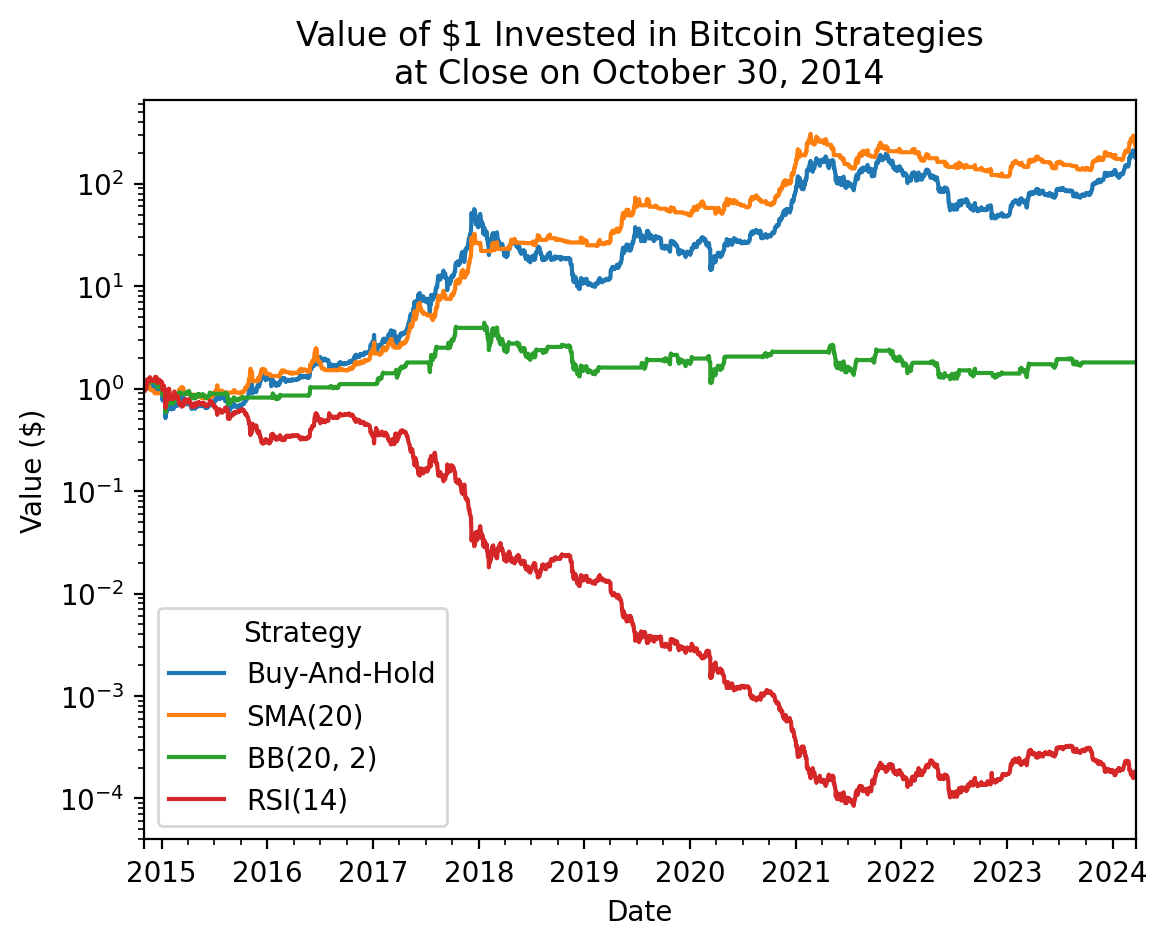

In [32]:
_ = (
    btc_sma[['Return', 'Strategy']]
    .join(
        btc_bb[['Strategy']].add_suffix('_BB'), 
    )
    .join(
        btc_rsi[['Strategy']].add_suffix('_RSI'), 
    )
    .dropna()
)


(
    _
    .add(1)
    .cumprod()
    .rename_axis(columns='Strategy')
    .rename(columns=
            {
                'Return': 'Buy-And-Hold', 
                'Strategy': 'SMA(20)',
                'Strategy_BB': 'BB(20, 2)',
                'Strategy_RSI': 'RSI(14)',
            }
           )
    .plot(logy=True)
)

plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested in Bitcoin Strategies\nat Close on {_.index[0] - pd.offsets.Day(1):%B %d, %Y}')
plt.show()